## 1. DataSet import

In [1]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from prepare_datasets import *
from Helper_functions import *

X, y, feature_names, categorical_features, continuous_features, actionable_features= get_and_prepare_german_dataset()

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_pos = X[y == 1]
X_neg = X[y == 0]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [2]:
from Model import NeuralNetwork

model0 = NeuralNetwork(X.shape[1], 200, 2)
model1= NeuralNetwork(X.shape[1], 200, 2)
model2= NeuralNetwork(X.shape[1], 200, 2)
model3= NeuralNetwork(X.shape[1], 200, 2)
model4= NeuralNetwork(X.shape[1], 200, 2)
model5= NeuralNetwork(X.shape[1], 200, 2)
model6= NeuralNetwork(X.shape[1], 200, 2)

In [3]:
models = [model0,model1, model2, model3, model4, model5, model6]
lambdas = [0,0.05,0.1,0.15,0.2,0.25,0.3]

model_path = f"models/germanCredit_model_0.pth"
model0.load_state_dict(torch.load(model_path))
model0.eval()

# load saved weights
for lambda_model, lamda in zip(models[1:], lambdas[1:]):
    model_path = f"models/germanCredit_model_lambda_{lamda:.2f}.pth"
    lambda_model.load_state_dict(torch.load(model_path))
    lambda_model.eval()


## Setting Up Dice

In [4]:
import dice_ml

df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

dice_data = dice_ml.Data(
    dataframe=df,
    continuous_features=continuous_features,
    categorical_features=categorical_features,
    outcome_name='target'
)

class PyTorchModelWrapper:
    def __init__(self, model):
        self.model = model

    def predict_proba(self, x):
        self.model.eval()
        with torch.no_grad():
            x = x.values
            x = x.astype(np.float64)
            x_tensor = torch.FloatTensor(x)
            logits = self.model(x_tensor)
            probabilities = torch.softmax(logits, dim=1)
            return probabilities.numpy()

In [5]:
cost_of_recourses_l1 = []
cost_of_recourses_l2 = []

for model in models:

    X_false_negatives, X_true_negatives, _, _ = split_by_classification(model, X_neg)

    dice_model = dice_ml.Model(
        model=PyTorchModelWrapper(model),
        backend="sklearn",
        model_type='classifier'
    )

    exp = dice_ml.Dice(
        dice_data,
        dice_model,
        method="genetic"
    )

    query_df = pd.DataFrame(X_true_negatives.numpy(), columns=feature_names)

    dice_exp = exp.generate_counterfactuals(
        query_df,
        total_CFs=3,
        desired_class="opposite",
        features_to_vary=actionable_features
    )

    all_l1_distances = []
    all_l2_distances = []
    for i in range(len(X_true_negatives)):
        original = X_true_negatives[i]
        cf_df = dice_exp.cf_examples_list[i].final_cfs_df

        if cf_df is None or cf_df.empty:
            continue

        cf_values = cf_df[feature_names].values
        cf_tensor = torch.from_numpy(cf_values).float()
        l1_distances = torch.norm(original - cf_tensor, p=1, dim=1)
        l2_distances = torch.norm(original - cf_tensor, p=2, dim=1)
        all_l1_distances.extend(l1_distances.tolist())
        all_l2_distances.extend(l2_distances.tolist())


    # compute mean distance
    cost_of_recourses_l1.append(all_l1_distances)
    cost_of_recourses_l2.append(all_l2_distances)

    print(f"Mean L1 distance for negatively classified data using DiCE: {np.mean(all_l1_distances):.2f}")
    print(f"Mean L2 distance for negatively classified data using DiCE: {np.mean(all_l2_distances):.2f}")

100%|██████████| 122/122 [10:48<00:00,  5.31s/it]


Mean L1 distance for negatively classified data using DiCE: 1936.20
Mean L2 distance for negatively classified data using DiCE: 1922.67


100%|██████████| 155/155 [21:12<00:00,  8.21s/it] 


Mean L1 distance for negatively classified data using DiCE: 2073.99
Mean L2 distance for negatively classified data using DiCE: 2059.00


100%|██████████| 183/183 [10:31<00:00,  3.45s/it]


Mean L1 distance for negatively classified data using DiCE: 2266.45
Mean L2 distance for negatively classified data using DiCE: 2249.98


100%|██████████| 210/210 [20:19<00:00,  5.81s/it] 


Mean L1 distance for negatively classified data using DiCE: 2306.32
Mean L2 distance for negatively classified data using DiCE: 2290.33


100%|██████████| 228/228 [11:26<00:00,  3.01s/it] 


Mean L1 distance for negatively classified data using DiCE: 2457.01
Mean L2 distance for negatively classified data using DiCE: 2440.29


100%|██████████| 248/248 [12:42<00:00,  3.07s/it] 


Mean L1 distance for negatively classified data using DiCE: 2360.01
Mean L2 distance for negatively classified data using DiCE: 2343.72


100%|██████████| 258/258 [10:09<00:00,  2.36s/it] 


Mean L1 distance for negatively classified data using DiCE: 2365.52
Mean L2 distance for negatively classified data using DiCE: 2349.24


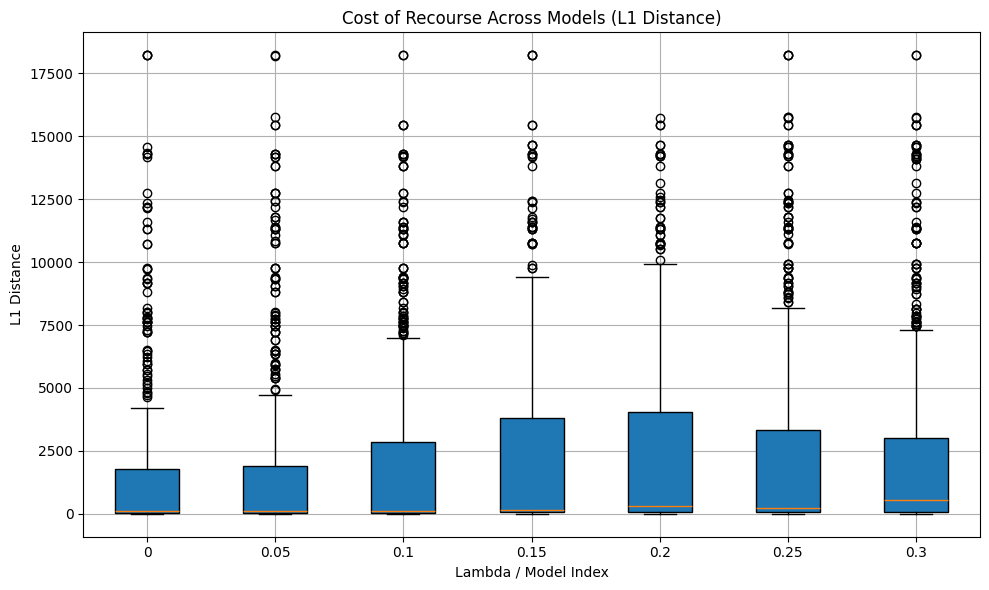

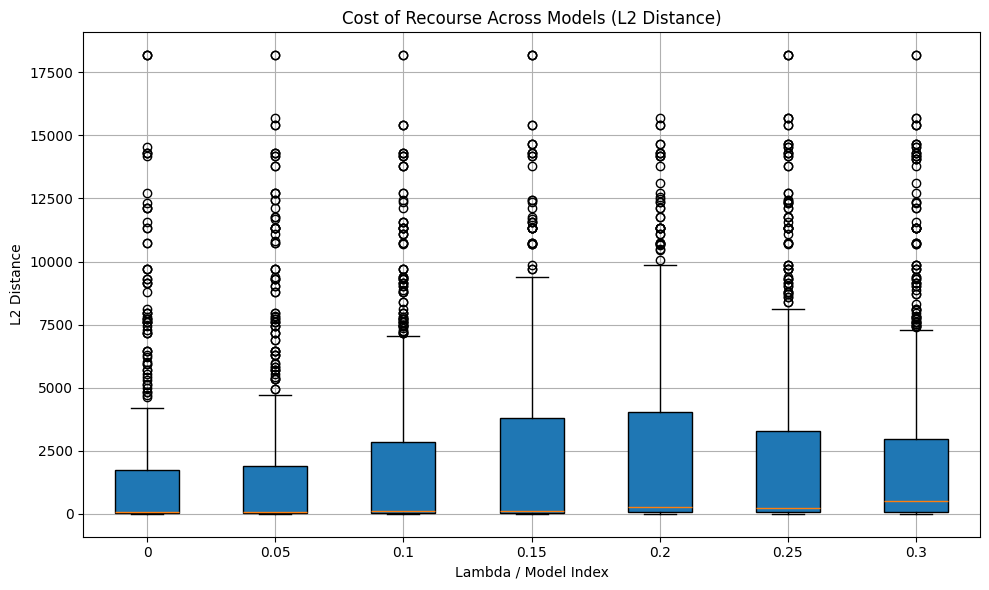

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot(cost_of_recourses_l1,patch_artist=True, tick_labels=lambdas)
plt.title("Cost of Recourse Across Models (L1 Distance)")
plt.xlabel("Lambda / Model Index")
plt.ylabel("L1 Distance")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.boxplot(cost_of_recourses_l2,patch_artist=True, tick_labels=lambdas)
plt.title("Cost of Recourse Across Models (L2 Distance)")
plt.xlabel("Lambda / Model Index")
plt.ylabel("L2 Distance")
plt.grid(True)
plt.tight_layout()
plt.show()

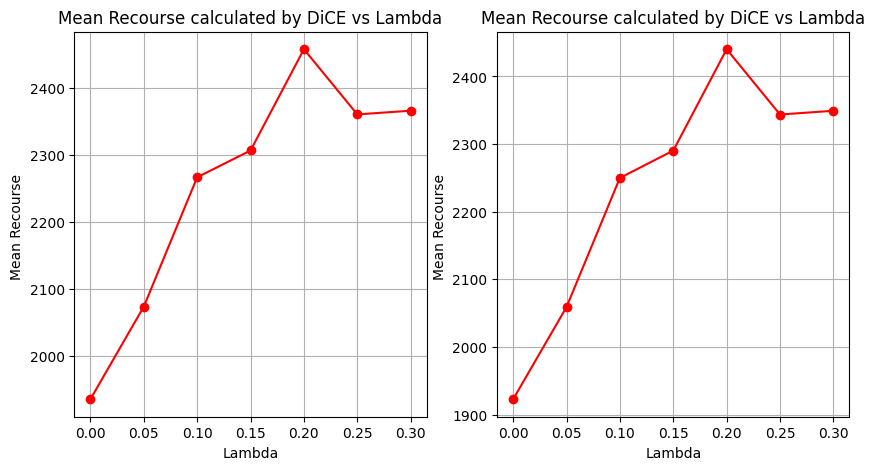

In [7]:
l1_means = [np.mean(sublist) for sublist in cost_of_recourses_l1]
l2_means = [np.mean(sublist) for sublist in cost_of_recourses_l2]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(lambdas, l1_means, marker='o', color='red')
plt.title("Mean Recourse calculated by DiCE vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Mean Recourse ")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(lambdas, l2_means, marker='o', color='red')
plt.title("Mean Recourse calculated by DiCE vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Mean Recourse ")
plt.grid(True)

## now we caluclate the counterfactuals only for instances that are classified as negative by all the models

In [10]:
commun_negatives = X_neg

for model in models:
    _, commun_negatives, _, _ = split_by_classification(model, commun_negatives)


In [11]:
cost_of_recourses_l1 = []
cost_of_recourses_l2 = []

for model in models:

    dice_model = dice_ml.Model(
        model=PyTorchModelWrapper(model),
        backend="sklearn",
        model_type='classifier'
    )

    exp = dice_ml.Dice(
        dice_data,
        dice_model,
        method="genetic"
    )

    query_df = pd.DataFrame(commun_negatives.numpy(), columns=feature_names)

    dice_exp = exp.generate_counterfactuals(
        query_df,
        total_CFs=3,
        desired_class="opposite",
        features_to_vary=actionable_features
    )

    all_l1_distances = []
    all_l2_distances = []
    for i in range(len(commun_negatives)):
        original = commun_negatives[i]
        cf_df = dice_exp.cf_examples_list[i].final_cfs_df

        if cf_df is None or cf_df.empty:
            continue

        cf_values = cf_df[feature_names].values
        cf_tensor = torch.from_numpy(cf_values).float()
        l1_distances = torch.norm(original - cf_tensor, p=1, dim=1)
        l2_distances = torch.norm(original - cf_tensor, p=2, dim=1)
        all_l1_distances.extend(l1_distances.tolist())
        all_l2_distances.extend(l2_distances.tolist())


    # compute mean distance
    cost_of_recourses_l1.append(all_l1_distances)
    cost_of_recourses_l2.append(all_l2_distances)

    print(f"Mean L1 distance for negatively classified data using DiCE: {np.mean(all_l1_distances):.2f}")
    print(f"Mean L2 distance for negatively classified data using DiCE: {np.mean(all_l2_distances):.2f}")

100%|██████████| 122/122 [08:48<00:00,  4.33s/it]


Mean L1 distance for negatively classified data using DiCE: 2142.61
Mean L2 distance for negatively classified data using DiCE: 2127.69


100%|██████████| 122/122 [12:25<00:00,  6.11s/it] 


Mean L1 distance for negatively classified data using DiCE: 2425.42
Mean L2 distance for negatively classified data using DiCE: 2409.79


100%|██████████| 122/122 [08:45<00:00,  4.31s/it]


Mean L1 distance for negatively classified data using DiCE: 2884.57
Mean L2 distance for negatively classified data using DiCE: 2867.11


100%|██████████| 122/122 [12:00<00:00,  5.91s/it]


Mean L1 distance for negatively classified data using DiCE: 2938.64
Mean L2 distance for negatively classified data using DiCE: 2920.50


100%|██████████| 122/122 [07:44<00:00,  3.80s/it]


Mean L1 distance for negatively classified data using DiCE: 3220.39
Mean L2 distance for negatively classified data using DiCE: 3201.29


100%|██████████| 122/122 [07:37<00:00,  3.75s/it]


Mean L1 distance for negatively classified data using DiCE: 3150.92
Mean L2 distance for negatively classified data using DiCE: 3132.62


100%|██████████| 122/122 [03:09<00:00,  1.55s/it]

Mean L1 distance for negatively classified data using DiCE: 3262.82
Mean L2 distance for negatively classified data using DiCE: 3243.03


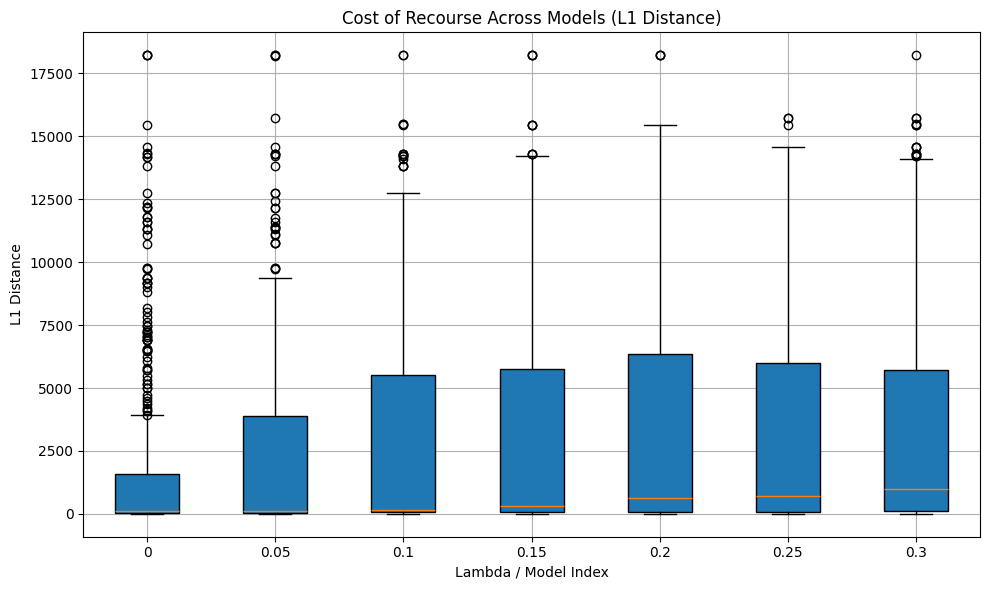

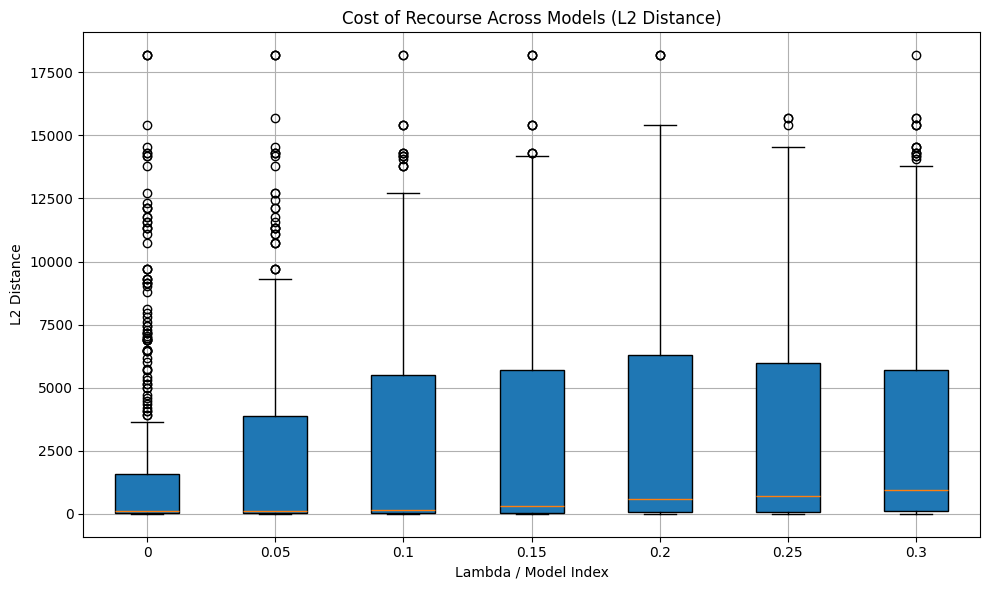

In [12]:
plt.figure(figsize=(10, 6))
plt.boxplot(cost_of_recourses_l1,patch_artist=True, tick_labels=lambdas)
plt.title("Cost of Recourse Across Models (L1 Distance)")
plt.xlabel("Lambda / Model Index")
plt.ylabel("L1 Distance")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.boxplot(cost_of_recourses_l2,patch_artist=True, tick_labels=lambdas)
plt.title("Cost of Recourse Across Models (L2 Distance)")
plt.xlabel("Lambda / Model Index")
plt.ylabel("L2 Distance")
plt.grid(True)
plt.tight_layout()
plt.show()

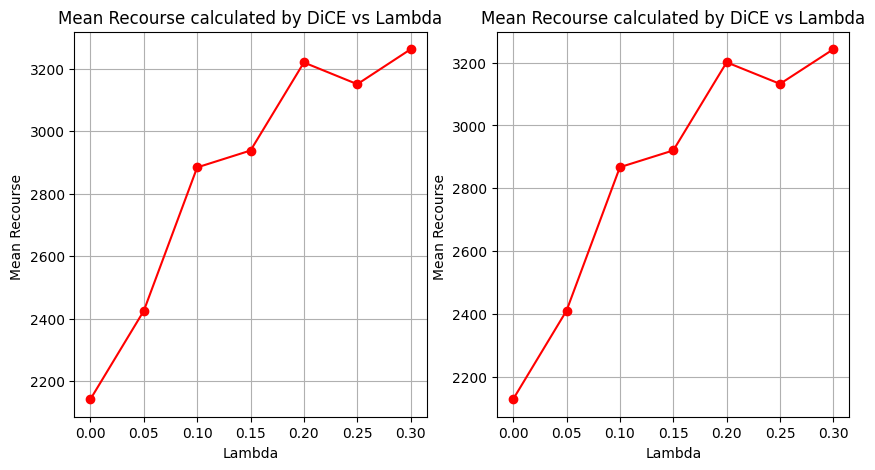

In [13]:
l1_means = [np.mean(sublist) for sublist in cost_of_recourses_l1]
l2_means = [np.mean(sublist) for sublist in cost_of_recourses_l2]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(lambdas, l1_means, marker='o', color='red')
plt.title("Mean Recourse calculated by DiCE vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Mean Recourse ")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(lambdas, l2_means, marker='o', color='red')
plt.title("Mean Recourse calculated by DiCE vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Mean Recourse ")
plt.grid(True)